In [1]:


%pip install scikit-learn xgboost shap matplotlib seaborn pandas numpy


import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.svm import SVC

import xgboost as xgb
import shap

print('Imports done')

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Imports done


In [2]:
df = pd.read_csv("data.csv")
print('Loaded', df.shape)
df.head()

Loaded (101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [4]:
df.describe()

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


In [5]:
df.isnull().sum()

encounter_id                    0
patient_nbr                     0
race                            0
gender                          0
age                             0
weight                          0
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                      0
medical_specialty               0
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                          0
diag_2                          0
diag_3                          0
number_diagnoses                0
max_glu_serum               96420
A1Cresult                   84748
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide 

In [6]:
df["weight"].value_counts()

weight
?            98569
[75-100)      1336
[50-75)        897
[100-125)      625
[125-150)      145
[25-50)         97
[0-25)          48
[150-175)       35
[175-200)       11
>200             3
Name: count, dtype: int64

In [7]:
# --- Step 1: Define mapping of bins to midpoints ---
midpoints = {
    "[75-100)": 87.5,
    "[50-75)": 62.5,
    "[100-125)": 112.5,
    "[125-150)": 137.5,
    "[25-50)": 37.5,
    "[0-25)": 12.5,
    "[150-175)": 162.5,
    "[175-200)": 187.5,
    ">200": 210
}

# --- Step 2: Compute weighted mean from non-missing bins ---
# Make a temporary frequency table
freq_table = df["weight"].value_counts()

# Keep only bins with defined midpoints
valid_bins = {k: v for k, v in freq_table.items() if k in midpoints}

# Compute weighted mean
weighted_mean = np.average(
    [midpoints[b] for b in valid_bins.keys()],
    weights=[valid_bins[b] for b in valid_bins.keys()]
)

print("Weighted mean value to fill '?':", weighted_mean)

# --- Step 3: Replace values in original dataset ---
# Map bins → midpoints
df["weight"] = df["weight"].replace(midpoints)

# Replace '?' → weighted mean
df["weight"] = df["weight"].replace("?", weighted_mean).astype(float)

# --- Step 4: Verify ---
print(df["weight"].head(20))  # show first 20 rows after replacement


Weighted mean value to fill '?': 86.27776040037536
0     86.27776
1     86.27776
2     86.27776
3     86.27776
4     86.27776
5     86.27776
6     86.27776
7     86.27776
8     86.27776
9     86.27776
10    86.27776
11    86.27776
12    86.27776
13    86.27776
14    86.27776
15    86.27776
16    86.27776
17    86.27776
18    86.27776
19    86.27776
Name: weight, dtype: float64


In [8]:
df.head()


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),86.27776,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),86.27776,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),86.27776,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),86.27776,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),86.27776,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [9]:
df["payer_code"].value_counts()

payer_code
?     40256
MC    32439
HM     6274
SP     5007
BC     4655
MD     3532
CP     2533
UN     2448
CM     1937
OG     1033
PO      592
DM      549
CH      146
WC      135
OT       95
MP       79
SI       55
FR        1
Name: count, dtype: int64

In [10]:
# --- Proportional sampling imputation for payer_code ---

# assume your DataFrame is named df and payer column is 'payer_code'
# make a defensive copy if you want to keep original
df = df.copy()

# Normalize representations: treat empty strings / NaN as missing too
df['payer_code'] = df['payer_code'].astype(str).replace({'nan': np.nan, 'None': np.nan, '': np.nan})

# Show counts before
print("Before imputation:\n", df['payer_code'].value_counts(dropna=False))

# Build distribution of observed (non-missing, non-'?') categories
observed = df['payer_code'][~df['payer_code'].isin(['?', np.nan])].value_counts()
if observed.sum() == 0:
    raise ValueError("No non-missing payer_code values to build distribution from.")

probs = observed / observed.sum()

# Indices to fill (treat both '?' and explicit NaN as missing)
mask_missing = df['payer_code'].isin(['?']) | df['payer_code'].isna()
missing_idx = df.index[mask_missing]

# If there are missing entries, sample according to observed distribution
if len(missing_idx) > 0:
    rng = np.random.default_rng(42)  # reproducible
    sampled_values = rng.choice(probs.index.to_numpy(), size=len(missing_idx), p=probs.values)
    df.loc[missing_idx, 'payer_code'] = sampled_values

# Verify after
print("\nAfter imputation:\n", df['payer_code'].value_counts(dropna=False))


Before imputation:
 payer_code
?     40256
MC    32439
HM     6274
SP     5007
BC     4655
MD     3532
CP     2533
UN     2448
CM     1937
OG     1033
PO      592
DM      549
CH      146
WC      135
OT       95
MP       79
SI       55
FR        1
Name: count, dtype: int64

After imputation:
 payer_code
MC    53592
HM    10366
SP     8298
BC     7759
MD     5878
CP     4210
UN     4020
CM     3179
OG     1738
PO      964
DM      882
CH      254
WC      236
OT      171
MP      126
SI       92
FR        1
Name: count, dtype: int64


In [11]:
df["medical_specialty"].value_counts()

medical_specialty
?                         49949
InternalMedicine          14635
Emergency/Trauma           7565
Family/GeneralPractice     7440
Cardiology                 5352
                          ...  
Proctology                    1
Speech                        1
SportsMedicine                1
Perinatology                  1
Neurophysiology               1
Name: count, Length: 73, dtype: int64

In [12]:
df["medical_specialty"].unique()

array(['Pediatrics-Endocrinology', '?', 'InternalMedicine',
       'Family/GeneralPractice', 'Cardiology', 'Surgery-General',
       'Orthopedics', 'Gastroenterology',
       'Surgery-Cardiovascular/Thoracic', 'Nephrology',
       'Orthopedics-Reconstructive', 'Psychiatry', 'Emergency/Trauma',
       'Pulmonology', 'Surgery-Neuro',
       'Obsterics&Gynecology-GynecologicOnco', 'ObstetricsandGynecology',
       'Pediatrics', 'Hematology/Oncology', 'Otolaryngology',
       'Surgery-Colon&Rectal', 'Pediatrics-CriticalCare', 'Endocrinology',
       'Urology', 'Psychiatry-Child/Adolescent', 'Pediatrics-Pulmonology',
       'Neurology', 'Anesthesiology-Pediatric', 'Radiology',
       'Pediatrics-Hematology-Oncology', 'Psychology', 'Podiatry',
       'Gynecology', 'Oncology', 'Pediatrics-Neurology',
       'Surgery-Plastic', 'Surgery-Thoracic',
       'Surgery-PlasticwithinHeadandNeck', 'Ophthalmology',
       'Surgery-Pediatric', 'Pediatrics-EmergencyMedicine',
       'PhysicalMedicineandRe

In [13]:
df_impute = df.copy()

# Identify rows with missing specialty
missing_mask = df_impute['medical_specialty'] == '?'

# Optional: Drop rows where other key features are also missing (adjust as needed)
# For example, if diag_1 is critical:
# df_impute = df_impute.dropna(subset=['diag_1'])

# Select features you'll use for prediction (example)
feature_cols = [ 'age', 'gender', 'weight',
    'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
    'time_in_hospital', 'num_lab_procedures', 'num_medications',
    'number_outpatient', 'number_emergency', 'number_inpatient',
    'diag_1', 'diag_2', 'diag_3',
    'payer_code']

# Keep only rows where medical_specialty is NOT missing for training
train_data = df_impute[~missing_mask].copy()
test_data = df_impute[missing_mask].copy()

from sklearn.preprocessing import LabelEncoder

# Encode categorical features (including target)
label_encoders = {}
for col in feature_cols:
    if df_impute[col].dtype == 'object':
        le = LabelEncoder()
        # Fit on all data to avoid unseen labels
        all_vals = pd.concat([df_impute[col].fillna('MISSING')], axis=0)
        le.fit(all_vals.astype(str))
        label_encoders[col] = le
        train_data[col] = le.transform(train_data[col].fillna('MISSING').astype(str))
        test_data[col] = le.transform(test_data[col].fillna('MISSING').astype(str))

# Encode target
target_encoder = LabelEncoder()
train_data['medical_specialty_encoded'] = target_encoder.fit_transform(train_data['medical_specialty'])

In [14]:
# Prepare X and y
X_train = train_data[feature_cols]
y_train = train_data['medical_specialty_encoded']

# Handle any remaining NaNs in features (e.g., with simple imputation)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='most_frequent')
X_train_imputed = imputer.fit_transform(X_train)

# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train_imputed, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [15]:
# Impute missing values in test features
X_test = test_data[feature_cols]
X_test_imputed = imputer.transform(X_test)

# Predict
y_pred_encoded = clf.predict(X_test_imputed)
y_pred = target_encoder.inverse_transform(y_pred_encoded)

# Assign predictions back to original DataFrame
df.loc[missing_mask, 'medical_specialty'] = y_pred

In [16]:
df["medical_specialty"].value_counts()
# The '?' count should now be 0

medical_specialty
InternalMedicine          44943
Family/GeneralPractice    12815
Emergency/Trauma          12177
Cardiology                 9218
Surgery-General            4593
                          ...  
Proctology                    1
Psychiatry-Addictive          1
SportsMedicine                1
Perinatology                  1
Neurophysiology               1
Name: count, Length: 72, dtype: int64

In [17]:


def impute_categorical_targets(df, target_cols, feature_cols, missing_marker='?'):
    """
    Impute missing values in multiple categorical columns using Random Forest.
    
    Parameters:
    - df: pandas DataFrame (modified in place)
    - target_cols: list of column names to impute (e.g., ['medical_specialty', 'admission_type'])
    - feature_cols: list of predictor column names
    - missing_marker: value representing missingness (e.g., '?', np.nan)
    """
    # Make a working copy for safety during encoding
    df_work = df.copy()
    
    # Replace missing marker with NaN for uniform handling
    for col in target_cols:
        if missing_marker != np.nan:
            df_work[col] = df_work[col].replace(missing_marker, np.nan)
    
    # Prepare feature data: encode categoricals, impute missing in features
    feature_data = df_work[feature_cols].copy()
    label_encoders_features = {}
    
    # Encode categorical features
    for col in feature_cols:
        if feature_data[col].dtype == 'object':
            le = LabelEncoder()
            # Fill NaN temporarily for encoding
            feature_data[col] = feature_data[col].fillna('MISSING')
            le.fit(pd.concat([feature_data[col], pd.Series(['MISSING'])]))
            feature_data[col] = le.transform(feature_data[col])
            label_encoders_features[col] = le
    
    # Impute missing in features (in case any remain)
    feature_imputer = SimpleImputer(strategy='most_frequent')
    X_full = feature_imputer.fit_transform(feature_data)
    
    # Impute each target column
    for target in target_cols:
        print(f"Imputing missing values in: {target}")
        
        # Identify missing and non-missing rows
        missing_mask = df_work[target].isna()
        if not missing_mask.any():
            print(f"  → No missing values in {target}. Skipping.")
            continue
        
        # Training data: rows where target is NOT missing
        train_idx = ~missing_mask
        X_train = X_full[train_idx]
        y_train = df_work.loc[train_idx, target]
        
        # Encode target
        le_target = LabelEncoder()
        y_train_encoded = le_target.fit_transform(y_train)
        
        # Train classifier
        clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        clf.fit(X_train, y_train_encoded)
        
        # Predict missing values
        X_test = X_full[missing_mask]
        y_pred_encoded = clf.predict(X_test)
        y_pred = le_target.inverse_transform(y_pred_encoded)
        
        # Update original DataFrame
        df.loc[missing_mask, target] = y_pred

# -----------------------------
# Example Usage
# -----------------------------

# Define your columns
target_columns = [
 'diag_1',
 'diag_2',
 'diag_3',
 'max_glu_serum',
 'A1Cresult',]
feature_columns = [ 'age', 'gender',  'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide', 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change',
 'diabetesMed',
'payer_code']

# Clean feature columns: ensure they don't contain '?' or inconsistent types
for col in feature_columns:
    if df[col].dtype == 'object':
        df[col] = df[col].replace('?', np.nan)

# Run imputation
impute_categorical_targets(
    df=df,
    target_cols=target_columns,
    feature_cols=feature_columns,
    missing_marker='?'  # or np.nan if your missing values are already NaN
)

# Verify
for col in target_columns:
    print(f"\nValue counts for {col}:")
    print(df[col].value_counts().head())

Imputing missing values in: diag_1
Imputing missing values in: diag_2
Imputing missing values in: diag_3
Imputing missing values in: max_glu_serum
Imputing missing values in: A1Cresult

Value counts for diag_1:
diag_1
428    6868
414    6590
786    4016
410    3614
486    3508
Name: count, dtype: int64

Value counts for diag_2:
diag_2
276    6928
428    6702
250    6104
427    5058
401    3742
Name: count, dtype: int64

Value counts for diag_3:
diag_3
250    12134
401     8435
276     5422
428     4606
427     3973
Name: count, dtype: int64

Value counts for max_glu_serum:
max_glu_serum
Norm    59074
>200    23463
>300    19229
Name: count, dtype: int64

Value counts for A1Cresult:
A1Cresult
>8      51842
Norm    35743
>7      14181
Name: count, dtype: int64


In [18]:
df.isnull().sum()

encounter_id                0
patient_nbr                 0
race                        0
gender                      0
age                         0
weight                      0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
payer_code                  0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazo

In [19]:
RANDOM_STATE = 42
CALIB_HOLDOUT = 0.10         # proportion of training used for calibration + threshold tuning
SHAP_SAMPLE = 1000           # subset size for SHAP (keep moderate)
N_ESTIMATORS_RF = 100        # reduce for speed; increase if you have budget
N_ESTIMATORS_XGB = 100

# --------------------------
# 1) Prepare X and y
# --------------------------
# adjust if your target encoding differs
target_col = 'readmitted'
id_cols = ['encounter_id', 'patient_nbr']  # drop ids from features

if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found in df")

# Create binary target: 1 if '<30', else 0
y = (df[target_col] == '<30').astype(int)

# Build X by dropping target and id columns
X = df.drop(columns=[c for c in [target_col] + id_cols if c in df.columns]).copy()


In [20]:
numeric_cols = X.select_dtypes(include=['int64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

print(f"Numeric cols: {len(numeric_cols)}, Categorical cols: {len(cat_cols)}")

Numeric cols: 11, Categorical cols: 35


In [21]:
num_pipe = Pipeline([
    ('imputer', IterativeImputer(estimator=BayesianRidge(), max_iter=5, random_state=RANDOM_STATE)),
    ('scaler', StandardScaler())
])

# Safe OneHotEncoder parameter for different sklearn versions
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=True)

cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', ohe)
])

In [22]:
transformers = []
if numeric_cols:
    transformers.append(('num', num_pipe, numeric_cols))
if cat_cols:
    transformers.append(('cat', cat_pipe, cat_cols))

from sklearn.compose import ColumnTransformer
preproc = ColumnTransformer(transformers=transformers, remainder='drop')

In [23]:
from sklearn.model_selection import train_test_split

# if you have a date column, prefer temporal split. Here we do stratified split:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)
print("Train/Test shapes:", X_train.shape, X_test.shape)

# Fit preprocessor and transform (do this once to speed up repeated model training)
print("Fitting preprocessing... (this may take a moment)")
preproc.fit(X_train)

X_train_t = preproc.transform(X_train)   # may be sparse
X_test_t  = preproc.transform(X_test)

Train/Test shapes: (81412, 47) (20354, 47)
Fitting preprocessing... (this may take a moment)


In [24]:
from scipy import sparse
if sparse.issparse(X_train_t):
    print("Converting transformed features to dense arrays (be mindful of memory).")
    X_train_t = X_train_t.toarray()
    X_test_t  = X_test_t.toarray()

# Obtain feature names for SHAP and reporting
try:
    feature_names = preproc.get_feature_names_out()
except:
    # fallback
    feature_names = [f'f{i}' for i in range(X_train_t.shape[1])]

# --------------------------
# 4) Small holdout for calibration & threshold tuning
# --------------------------
X_tr_t, X_cal_t, y_tr, y_cal = train_test_split(
    X_train_t, y_train, test_size=CALIB_HOLDOUT, stratify=y_train, random_state=RANDOM_STATE
)
print("Training subset shape:", X_tr_t.shape, "Calibration subset shape:", X_cal_t.shape)


Converting transformed features to dense arrays (be mindful of memory).
Training subset shape: (73270, 2363) Calibration subset shape: (8142, 2363)


In [25]:
# 5) Define and train "fast" models with imbalance handling
# --------------------------
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except Exception:
    XGBOOST_AVAILABLE = False
    print("Warning: xgboost not installed or failed to import. XGBoost will be skipped.")


In [26]:
# RandomForest with class_weight balanced
rf_clf = RandomForestClassifier(
    n_estimators=N_ESTIMATORS_RF, max_depth=12, max_features='sqrt',
    class_weight='balanced', n_jobs=-1, random_state=RANDOM_STATE
)
print("Fitting RandomForest...")
rf_clf.fit(X_tr_t, y_tr)

# XGBoost with scale_pos_weight (fast hist)
if XGBOOST_AVAILABLE:
    n_pos = int(y_tr.sum())
    n_neg = int(len(y_tr) - n_pos)
    scale_pos_weight = max(1.0, n_neg / max(1, n_pos))
    xgb_clf = xgb.XGBClassifier(
        n_estimators=N_ESTIMATORS_XGB, max_depth=6, subsample=0.8, colsample_bytree=0.8,
        tree_method='hist', use_label_encoder=False, eval_metric='logloss',
        scale_pos_weight=scale_pos_weight, random_state=RANDOM_STATE, n_jobs=-1
    )
    print("Fitting XGBoost...")
    xgb_clf.fit(X_tr_t, y_tr)
else:
    xgb_clf = None

# LinearSVC (fast linear model) with class_weight balanced
lsvc = LinearSVC(max_iter=20000, dual=False, class_weight='balanced', random_state=RANDOM_STATE)
print("Fitting LinearSVC (fast)...")
lsvc.fit(X_tr_t, y_tr)

Fitting RandomForest...
Fitting XGBoost...
Fitting LinearSVC (fast)...


,penalty,'l2'
,loss,'squared_hinge'
,dual,False
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,verbose,0
,random_state,42


In [27]:
# 6) Calibrate probabilities (fast: sigmoid) using calibration holdout
# --------------------------
from sklearn.calibration import CalibratedClassifierCV
print("Calibrating models (sigmoid)...")
rf_cal = CalibratedClassifierCV(rf_clf, method='sigmoid', cv='prefit')
rf_cal.fit(X_cal_t, y_cal)

if XGBOOST_AVAILABLE:
    xgb_cal = CalibratedClassifierCV(xgb_clf, method='sigmoid', cv='prefit')
    xgb_cal.fit(X_cal_t, y_cal)
else:
    xgb_cal = None

svm_cal = CalibratedClassifierCV(lsvc, method='sigmoid', cv='prefit')
svm_cal.fit(X_cal_t, y_cal)

Calibrating models (sigmoid)...


,estimator,LinearSVC(cla...ndom_state=42)
,method,'sigmoid'
,cv,'prefit'
,n_jobs,None
,ensemble,'auto'
,penalty,'l2'
,loss,'squared_hinge'
,dual,False
,tol,0.0001
,C,1.0
,multi_class,'ovr'


In [28]:
# 7) Helper: find best threshold on calibration set (maximize F1) 
# --------------------------
from sklearn.metrics import f1_score

def find_best_threshold_by_f1(clf, X_val, y_val, grid=None):
    if grid is None:
        grid = np.linspace(0.01, 0.99, 99)
    probs = clf.predict_proba(X_val)[:,1]
    best_t, best_f1 = 0.5, -1
    for t in grid:
        preds = (probs >= t).astype(int)
        f1 = f1_score(y_val, preds, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_t = t
    return best_t, best_f1

In [29]:
# compute best thresholds using calibration set
rf_best_t, rf_best_f1 = find_best_threshold_by_f1(rf_cal, X_cal_t, y_cal)
svm_best_t, svm_best_f1 = find_best_threshold_by_f1(svm_cal, X_cal_t, y_cal)
if XGBOOST_AVAILABLE:
    xgb_best_t, xgb_best_f1 = find_best_threshold_by_f1(xgb_cal, X_cal_t, y_cal)
else:
    xgb_best_t, xgb_best_f1 = 0.5, 0.0

print(f"Best threshold (RF) = {rf_best_t:.2f}, F1 on calib = {rf_best_f1:.3f}")
print(f"Best threshold (SVM)= {svm_best_t:.2f}, F1 on calib = {svm_best_f1:.3f}")
if XGBOOST_AVAILABLE:
    print(f"Best threshold (XGB)= {xgb_best_t:.2f}, F1 on calib = {xgb_best_f1:.3f}")


Best threshold (RF) = 0.14, F1 on calib = 0.260
Best threshold (SVM)= 0.12, F1 on calib = 0.254
Best threshold (XGB)= 0.12, F1 on calib = 0.261


In [32]:
# 8) Evaluation function for test set (metrics + plots)
# --------------------------
from sklearn.metrics import (
    brier_score_loss, roc_auc_score, roc_curve, confusion_matrix,
    accuracy_score, precision_score, recall_score
)
from sklearn.calibration import calibration_curve
import seaborn as sns

def eval_and_plot(name, clf, X_test_arr, y_test_arr, threshold=0.12, show_plots=True):
    probs = clf.predict_proba(X_test_arr)[:,1]
    preds = (probs >= threshold).astype(int)

    brier = brier_score_loss(y_test_arr, probs)
    roc_auc = roc_auc_score(y_test_arr, probs)
    acc = accuracy_score(y_test_arr, preds)
    prec = precision_score(y_test_arr, preds, zero_division=0)
    rec = recall_score(y_test_arr, preds, zero_division=0)
    f1 = f1_score(y_test_arr, preds, zero_division=0)
    cm = confusion_matrix(y_test_arr, preds)

    print(f"\n=== {name} (threshold={threshold:.2f}) ===")
    print(f"Brier: {brier:.4f} | ROC-AUC: {roc_auc:.4f}")
    print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")
    print("Confusion matrix:\n", cm)

    if show_plots:
        # ROC
        fpr, tpr, _ = roc_curve(y_test_arr, probs)
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
        plt.plot([0,1],[0,1],'--', color='grey')
        plt.title(f"ROC - {name}")
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.grid(alpha=0.3)
        plt.show()

        # Calibration
        frac_pos, mean_pred = calibration_curve(y_test_arr, probs, n_bins=10)
        plt.figure(figsize=(4,4))
        plt.plot(mean_pred, frac_pos, marker='o', label=name)
        plt.plot([0,1],[0,1],'--', color='k')
        plt.title(f"Calibration - {name}")
        plt.xlabel("Mean predicted prob"); plt.ylabel("Observed fraction positive"); plt.grid(alpha=0.3)
        plt.show()

        # Confusion matrix heatmap
        plt.figure(figsize=(4,3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"Confusion Matrix - {name}"); plt.xlabel("Predicted"); plt.ylabel("Actual")
        plt.show()

    return {
        'name': name, 'threshold': threshold, 'brier': brier, 'roc_auc': roc_auc,
        'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'cm': cm
    }


=== RandomForest (threshold=0.14) ===
Brier: 0.0959 | ROC-AUC: 0.6530
Accuracy: 0.7368 | Precision: 0.1889 | Recall: 0.4126 | F1: 0.2592
Confusion matrix:
 [[14060  4023]
 [ 1334   937]]


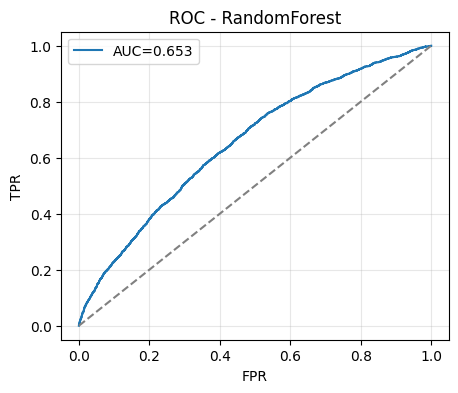

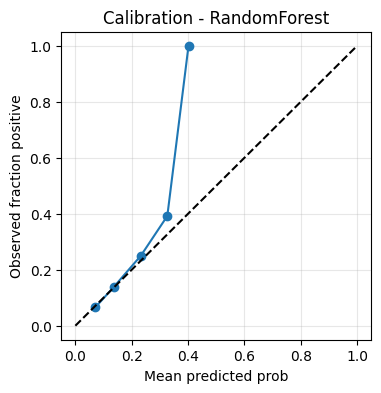

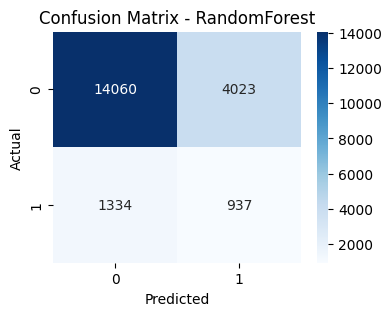


=== XGBoost (threshold=0.12) ===
Brier: 0.0952 | ROC-AUC: 0.6639
Accuracy: 0.6465 | Precision: 0.1726 | Recall: 0.5716 | F1: 0.2651
Confusion matrix:
 [[11861  6222]
 [  973  1298]]


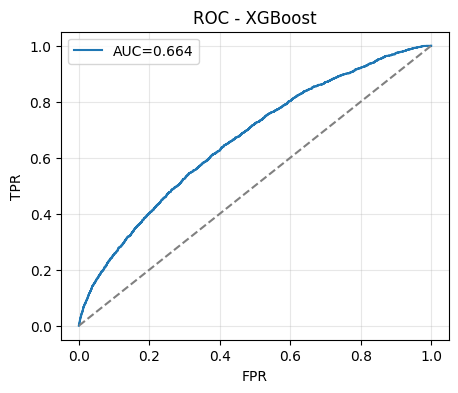

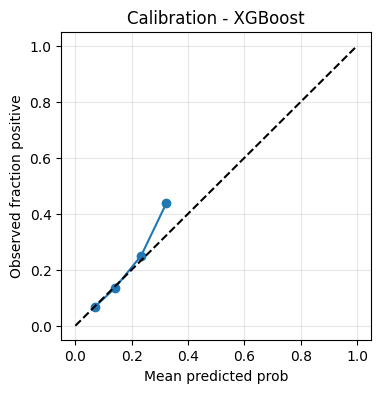

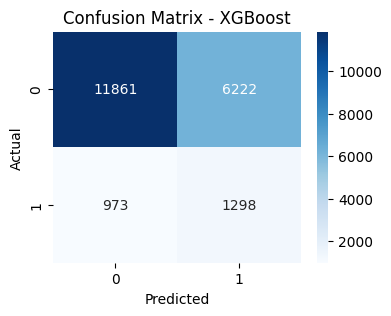


=== LinearSVC (threshold=0.12) ===
Brier: 0.0963 | ROC-AUC: 0.6346
Accuracy: 0.6641 | Precision: 0.1685 | Recall: 0.5108 | F1: 0.2534
Confusion matrix:
 [[12357  5726]
 [ 1111  1160]]


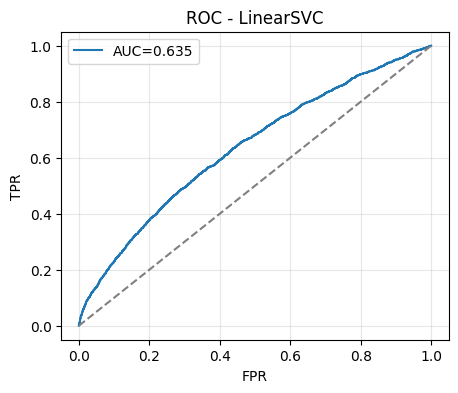

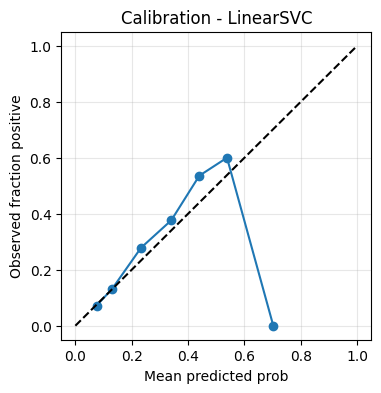

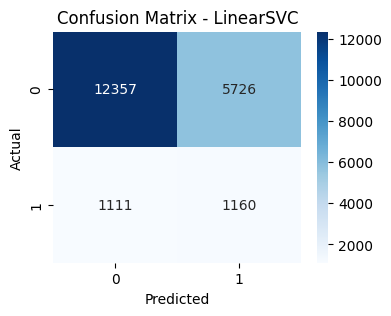


=== RandomForest (best-t) (threshold=0.14) ===
Brier: 0.0959 | ROC-AUC: 0.6530
Accuracy: 0.7368 | Precision: 0.1889 | Recall: 0.4126 | F1: 0.2592
Confusion matrix:
 [[14060  4023]
 [ 1334   937]]


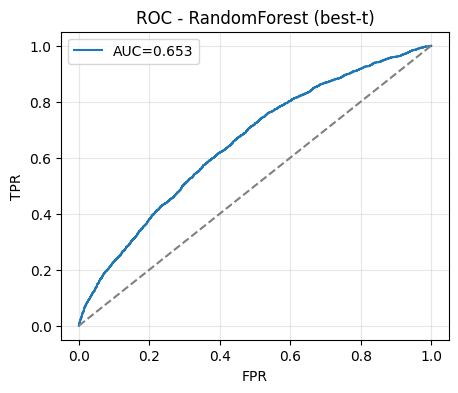

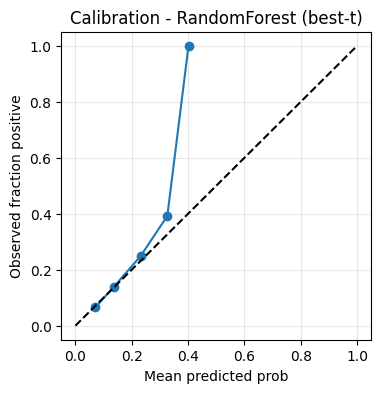

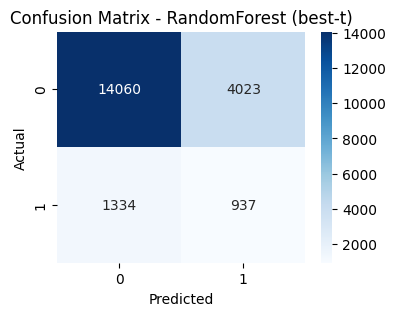


=== XGBoost (best-t) (threshold=0.12) ===
Brier: 0.0952 | ROC-AUC: 0.6639
Accuracy: 0.6465 | Precision: 0.1726 | Recall: 0.5716 | F1: 0.2651
Confusion matrix:
 [[11861  6222]
 [  973  1298]]


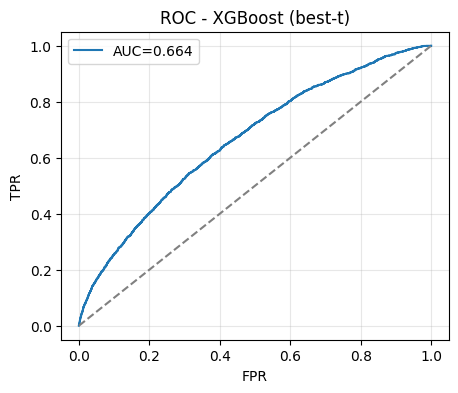

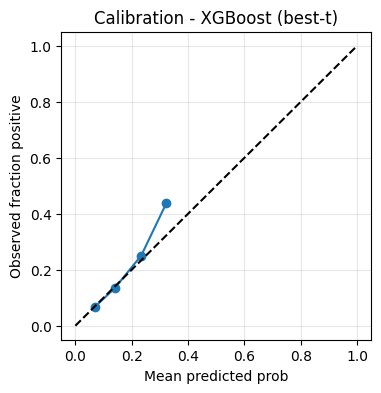

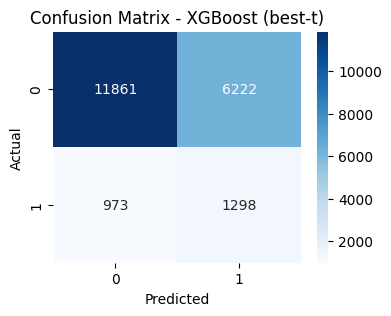


=== LinearSVC (best-t) (threshold=0.12) ===
Brier: 0.0963 | ROC-AUC: 0.6346
Accuracy: 0.6641 | Precision: 0.1685 | Recall: 0.5108 | F1: 0.2534
Confusion matrix:
 [[12357  5726]
 [ 1111  1160]]


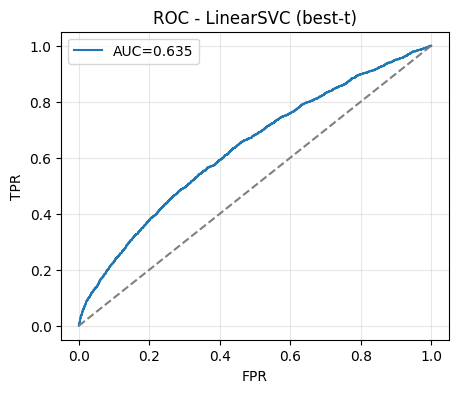

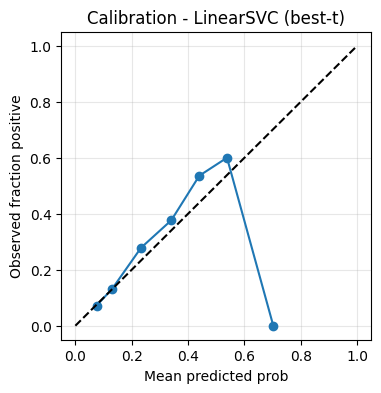

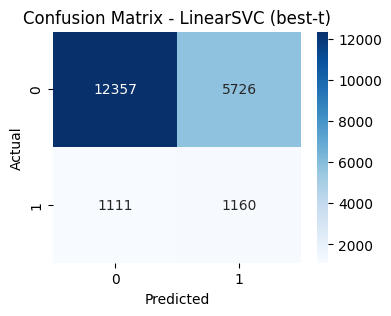

In [33]:
# Evaluate at default 0.5
results = []
results.append(eval_and_plot('RandomForest', rf_cal, X_test_t, y_test, threshold=0.14))
if XGBOOST_AVAILABLE:
    results.append(eval_and_plot('XGBoost', xgb_cal, X_test_t, y_test, threshold=0.12))
results.append(eval_and_plot('LinearSVC', svm_cal, X_test_t, y_test, threshold=0.12))

# Evaluate at best thresholds found on calibration set
results.append(eval_and_plot('RandomForest (best-t)', rf_cal, X_test_t, y_test, threshold=rf_best_t))
if XGBOOST_AVAILABLE:
    results.append(eval_and_plot('XGBoost (best-t)', xgb_cal, X_test_t, y_test, threshold=xgb_best_t))
results.append(eval_and_plot('LinearSVC (best-t)', svm_cal, X_test_t, y_test, threshold=svm_best_t))


In [34]:
# 9) Build summary table and pick best model
# --------------------------
summary_df = pd.DataFrame([{
    'model': r['name'],
    'threshold': r['threshold'],
    'roc_auc': r['roc_auc'],
    'brier': r['brier'],
    'recall': r['recall'],
    'precision': r['precision'],
    'f1': r['f1'],
    'accuracy': r['accuracy']
} for r in results])

# prefer models by F1 at best threshold but show ROC-AUC too
print("\nSummary (best by F1 at tuned thresholds will be highlighted):")
display(summary_df.round(4))

best_by_f1 = summary_df.loc[summary_df['f1'].idxmax()]
best_by_roc = summary_df.loc[summary_df['roc_auc'].idxmax()]
print(f"\nBest by F1: {best_by_f1['model']} (threshold={best_by_f1['threshold']:.2f}, F1={best_by_f1['f1']:.4f})")
print(f"Best by ROC-AUC: {best_by_roc['model']} (ROC-AUC={best_by_roc['roc_auc']:.4f})")



Summary (best by F1 at tuned thresholds will be highlighted):


,model,threshold,roc_auc,brier,recall,precision,f1,accuracy
0,RandomForest,0.14,0.6530,0.0959,0.4126,0.1889,0.2592,0.7368
1,XGBoost,0.12,0.6639,0.0952,0.5716,0.1726,0.2651,0.6465
2,LinearSVC,0.12,0.6346,0.0963,0.5108,0.1685,0.2534,0.6641
3,RandomForest (best-t),0.14,0.6530,0.0959,0.4126,0.1889,0.2592,0.7368
4,XGBoost (best-t),0.12,0.6639,0.0952,0.5716,0.1726,0.2651,0.6465
5,LinearSVC (best-t),0.12,0.6346,0.0963,0.5108,0.1685,0.2534,0.6641



Best by F1: XGBoost (threshold=0.12, F1=0.2651)
Best by ROC-AUC: XGBoost (ROC-AUC=0.6639)


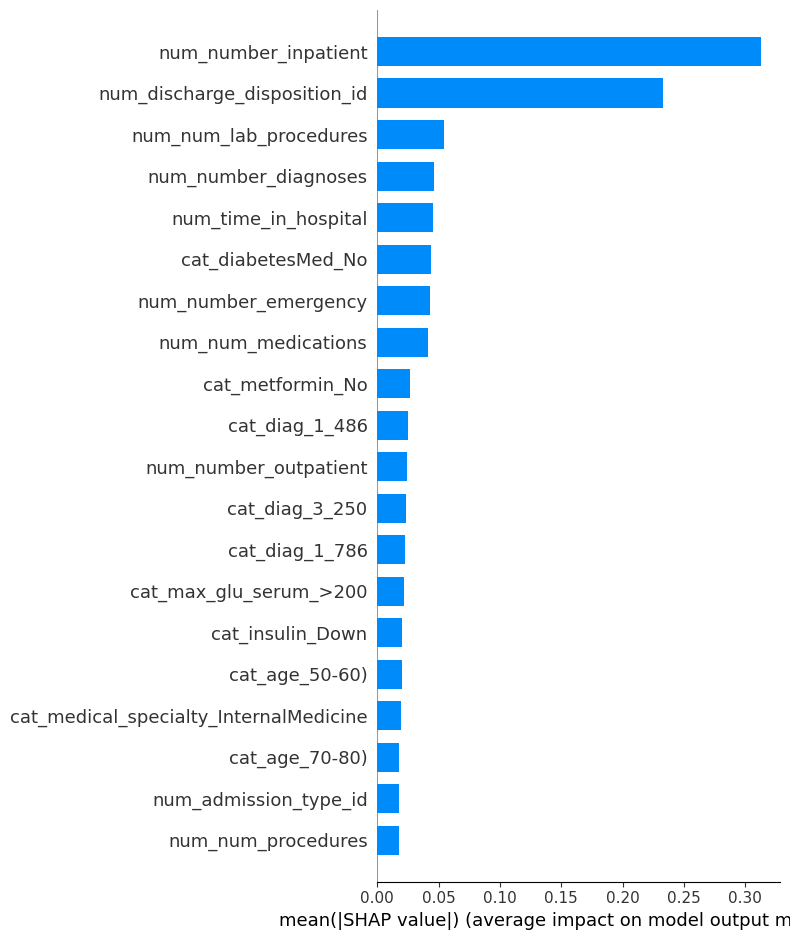

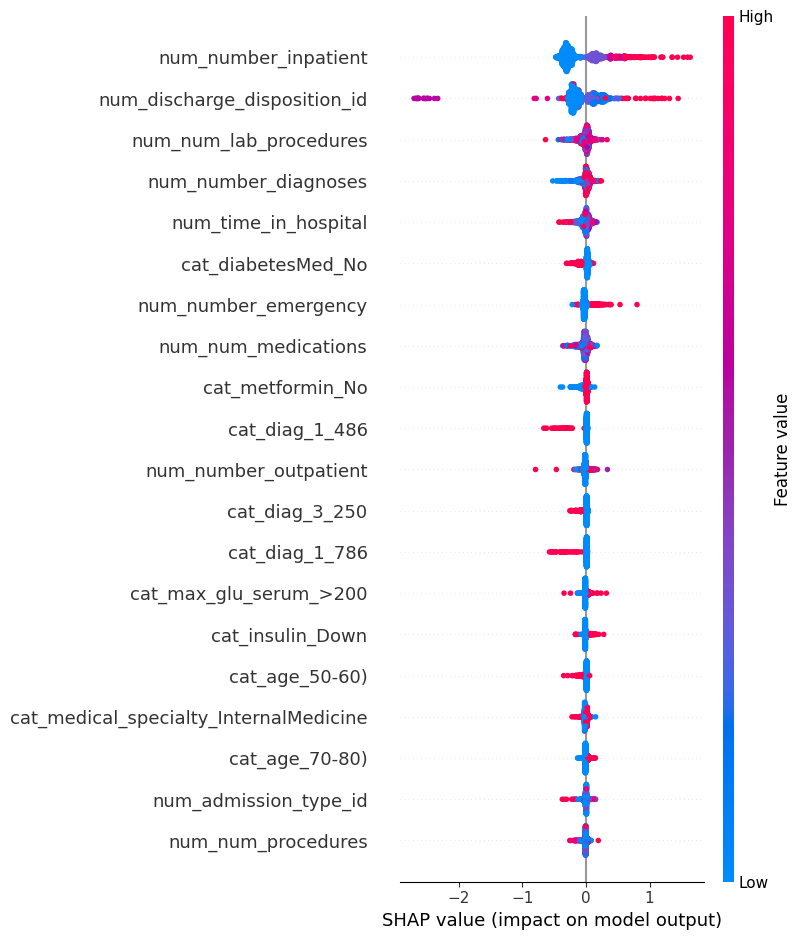

In [41]:
import shap
import pandas as pd
import re

# Subset for SHAP
n_shap = min(1000, X_test_t.shape[0])
X_shap_arr = X_test_t[:n_shap]

# Get raw feature names and clean them
raw_feature_names = preproc.get_feature_names_out()
# Remove or replace forbidden characters: [, ], <, and any non-alphanumeric (except underscore)
clean_feature_names = [
    re.sub(r'[\[\]<]', '_', name)          # Replace [ ] < with underscore
    .replace('__', '_')                    # Avoid double underscores
    .strip('_')                            # Remove leading/trailing underscores
    or f"feature_{i}"                      # Fallback if name becomes empty
    for i, name in enumerate(raw_feature_names)
]

# Ensure all names are valid strings (no duplicates needed, but safe)
clean_feature_names = [str(name) for name in clean_feature_names]

# Create DataFrame with clean names
X_shap_df = pd.DataFrame(X_shap_arr, columns=clean_feature_names)

# SHAP with XGBoost
explainer_xgb = shap.TreeExplainer(xgb_clf)
shap_values_xgb = explainer_xgb.shap_values(X_shap_df)

# Plots
shap.summary_plot(shap_values_xgb, X_shap_df, plot_type="bar")
shap.summary_plot(shap_values_xgb, X_shap_df)  # Beeswarm

In [42]:
# Predict on a few samples
sample_pred = xgb_clf.predict(X_test_t[:5])
sample_proba = xgb_clf.predict_proba(X_test_t[:5])

print("Predictions:", sample_pred)
print("Probabilities:", sample_proba)

Predictions: [1 0 0 1 0]
Probabilities: [[0.45691276 0.54308724]
 [0.7496233  0.25037673]
 [0.5009585  0.4990415 ]
 [0.28559572 0.7144043 ]
 [0.6530329  0.3469671 ]]


In [43]:
from sklearn.metrics import accuracy_score, roc_auc_score

train_pred = xgb_clf.predict(X_tr_t)
train_proba = xgb_clf.predict_proba(X_tr_t)[:, 1]

print("Train Accuracy:", accuracy_score(y_tr, train_pred))
print("Train ROC-AUC:", roc_auc_score(y_tr, train_proba))

Train Accuracy: 0.7146035212228743
Train ROC-AUC: 0.8003936159968118


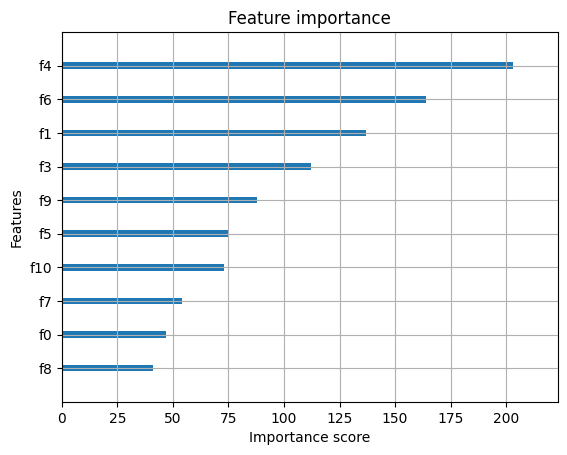

In [44]:
import matplotlib.pyplot as plt

# Plot top 10 features
xgb.plot_importance(xgb_clf, max_num_features=10, show_values=False)
plt.show()

In [45]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="stratified").fit(X_tr_t, y_tr)
dummy_auc = roc_auc_score(y_tr, dummy.predict_proba(X_tr_t)[:, 1])
xgb_auc = roc_auc_score(y_tr, xgb_clf.predict_proba(X_tr_t)[:, 1])

print(f"Dummy ROC-AUC: {dummy_auc:.3f}")
print(f"XGBoost ROC-AUC: {xgb_auc:.3f}")

Dummy ROC-AUC: 0.502
XGBoost ROC-AUC: 0.800
